## Multi-Task Regression 
This notebook demonstrates a supervised multi-task regression workflow for remote sensing using TorchGeo using the Digital Typhoon dataset. The objective is to predict multiple continuous typhoon intensity variables from satellite imagery using a deep learning model.

In [1]:
!pip install torchgeo --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 10.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 16.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 37.6 MB/s eta 0:00:00


In [ ]:
# IMPORTS
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import MeanAbsoluteError
from torchvision import transforms
from torchgeo.datasets import DigitalTyphoon
from torchgeo.datamodules import DigitalTyphoonDataModule
from torchgeo.models import vit_small_patch16_224, ViTSmall16_Weights
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger
import wandb
from kaggle_secrets import UserSecretsClient

In [29]:
# SEED & REPRODUCIBILITY
pl.seed_everything(42, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# WANDB SETUP
user_secrets = UserSecretsClient()
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("WANDB_API_KEY")

Seed set to 42


### Dataset Overview
The Digital Typhoon is derived from hourly infrared channel observations captured by multiple generations of the Himawari meteorological satellites, spanning the period from 1978. The satellite measurements have been converted to brightness temperatures and normalized across different sensors, resulting in a consistent spatio-temporal dataset covering more than four decades.

**Dataset features:**

* Infrared (IR) satellite imagery of 512 × 512 pixels at ~5km resolution
* Auxiliary metadata including wind speed, pressure and additional typhoon-related attributes
* 1,099 typhoons and 189,364 images

In [3]:
dataset = DigitalTyphoon(
    root="/kaggle/input/digitaltyphoon-sample2/WP_sampled",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False
)

dataset.__len__
dataset.__getitem__(index=0)

{'image': tensor([[[0.9183, 0.8847, 0.8538,  ..., 0.9072, 0.9146, 0.8961],
          [0.9292, 0.9292, 0.9292,  ..., 0.9219, 0.9146, 0.8961],
          [0.9328, 0.9292, 0.9292,  ..., 0.9146, 0.8998, 0.8809],
          ...,
          [0.8733, 0.8809, 0.9035,  ..., 0.2863, 0.2863, 0.2754],
          [0.8961, 0.9035, 0.9183,  ..., 0.2754, 0.2863, 0.2643],
          [0.9146, 0.9219, 0.9183,  ..., 0.2754, 0.2754, 0.2754]]]),
 'wind': tensor(-1.1474),
 'pressure': tensor(0.9933),
 'label': tensor([-1.1474,  0.9933])}

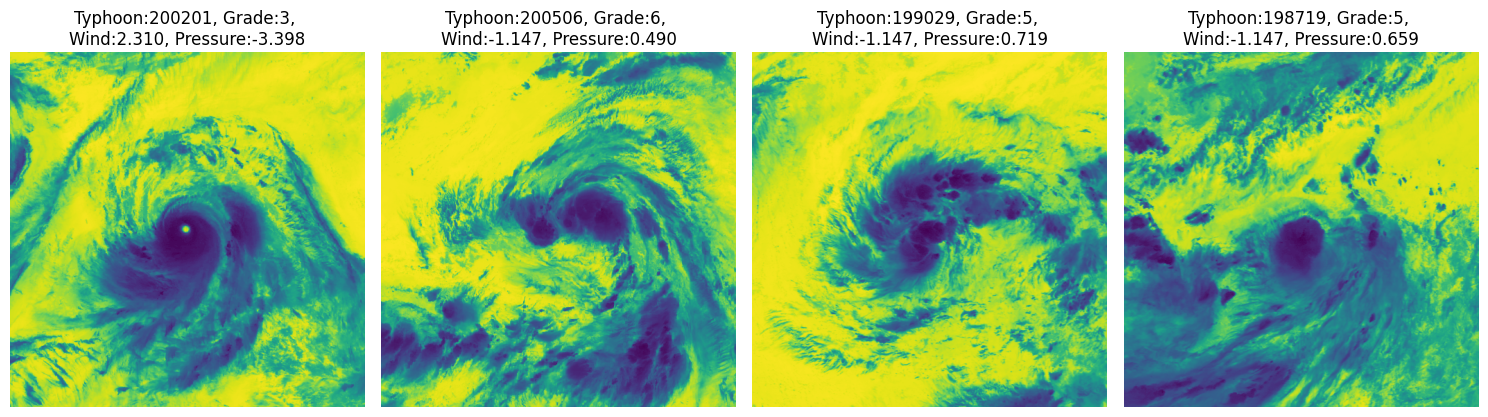

In [ ]:
# visualize input
aux_df = pd.read_csv("/kaggle/input/digitaltyphoon-sample2/WP_sampled/WP/aux_data.csv")
aux_df = aux_df.reset_index(drop=True)

# random indices
indices = np.random.choice(len(dataset), size=4, replace=False)

plt.figure(figsize=(15, 4))+

for i, idx in enumerate(indices):
    sample = dataset[idx]
    image = sample['image'].squeeze()
    wind = sample['wind']
    pressure = sample['pressure']

    row = aux_df.iloc[idx] # Lookup metadata from aux_df
    typhoon_id = row['id']
    grade = row['grade']

    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Typhoon:{typhoon_id}, Grade:{grade}, \nWind:{wind:.3f}, Pressure:{pressure:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Transform data and split data

In [6]:
# TRANSFORMS 
def typhoon_transform(sample, train=True):
    img = torch.as_tensor(sample["image"], dtype=torch.float32)
    if img.ndim == 2:
        img = img.unsqueeze(0)
    img = img.repeat(2, 1, 1)  # duplicate channel
    img = transforms.Resize((224, 224))(img)
    if train:
        img = transforms.RandomHorizontalFlip(p=0.5)(img)
        img = transforms.RandomVerticalFlip(p=0.3)(img)
        img = transforms.RandomRotation(degrees=25)(img)
        img = transforms.RandomAffine(degrees=0, translate=(0.12, 0.12), scale=(0.88, 1.12))(img)
        img = img + 0.02 * torch.randn_like(img)

    sample["image"] = img
    return sample

In [ ]:
# DATAMODULE
datamodule = DigitalTyphoonDataModule(
    root="/kaggle/input/digitaltyphoon-sample2/WP_sampled",
    split_by="typhoon_id",
    batch_size=16,
    num_workers=4,
    task="regression",
    features=["wind", "pressure"],
    targets=["wind", "pressure"],
    sequence_length=1,
    download=False,
    transforms=lambda x: typhoon_transform(x, train=True)  
)

datamodule.setup("fit")

# Override val transforms (no augmentation)
datamodule.val_dataset.dataset.transforms = lambda x: typhoon_transform(x, train=False)

### Model: Resnet50 backbone with two regression heads

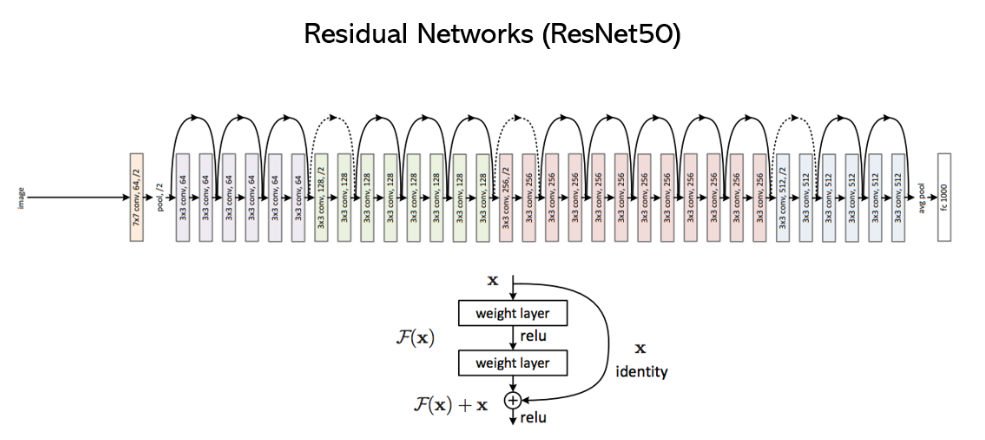

The architecture of ResNet involves: 
* Input Layer: The image data is fed into the network.
* Convolutional Layers: detect low-level features such as edges, textures, and patterns and generate feature maps.
* Max Pooling layers: They downsample the spatial dimensions of the feature maps, retaining important information and reducing computational load.
* Convolution and Residual Blocks: refining features and learning the difference (residual) between the input and output
* Skip Connections: These connections allow the input to bypass one or more layers, preserving the gradient during backpropagation, making it easier to train deep networks.
* Global Average Pooling: Instead of fully connected layers, it reduces the spatial dimensions of the feature maps to a single value per feature, simplifying the architecture.
* Output Layer with 2 regression heads: network adapted to split into 2 seperate MLP heads for predicting each continuous variable , maximum wind and centarl pressure


In [7]:
# MODEL 
class ResNet50TwoHead(pl.LightningModule):
    def __init__(
        self,
        learning_rate: float = 1e-4,
        dropout_rate: float = 0.35,
        loss_weight_wind: float = 1.2,
        loss_weight_pressure: float = 1.0,
        freeze_backbone: bool = False,
        pretrained: bool = True,
    ):
        super().__init__()
        self.save_hyperparameters()

        # Backbone: 
        weights = ResNet50_Weights.SENTINEL1_GRD_SOFTCON if pretrained else None
        self.backbone = resnet50(weights=weights)

        # Remove classification head
        self.backbone.fc = nn.Identity()
        
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        feature_size = 2048  # ResNet-50 output dim

        # Regression heads
        def make_head():
            return nn.Sequential(
                nn.Linear(feature_size, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate * 0.6),
                nn.Linear(128, 1),
            )

        self.head_wind = make_head()
        self.head_pressure = make_head()

        # Loss & metrics
        self.criterion = nn.MSELoss()
        self.train_mae_wind = MeanAbsoluteError()
        self.train_mae_pressure = MeanAbsoluteError()
        self.val_mae_wind = MeanAbsoluteError()
        self.val_mae_pressure = MeanAbsoluteError()
        self.test_mae_wind = MeanAbsoluteError()
        self.test_mae_pressure = MeanAbsoluteError()

        # Physical units for denormalized logging
        self.wind_mean = 59.2    # knots
        self.wind_std = 19.8
        self.press_mean = 983.8  # hPa
        self.press_std = 22.5

    # Forward pass
    def forward(self, x):
        features = self.backbone(x)  # [B, 2048]
        wind = self.head_wind(features)
        pressure = self.head_pressure(features)
        return torch.cat([wind, pressure], dim=1)

    # Shared step
    def _shared_step(self, batch, stage="train"):
        imgs = batch["image"]
        wind_true = batch["wind"].squeeze(-1)
        press_true = batch["pressure"].squeeze(-1)

        preds = self(imgs)

        loss_wind = self.criterion(preds[:, 0], wind_true)
        loss_pressure = self.criterion(preds[:, 1], press_true)

        total_loss = (
            self.hparams.loss_weight_wind * loss_wind
            + self.hparams.loss_weight_pressure * loss_pressure
        )

        # Normalized MAE
        getattr(self, f"{stage}_mae_wind")(preds[:, 0], wind_true)
        getattr(self, f"{stage}_mae_pressure")(preds[:, 1], press_true)

        # Denormalized MAE (physical units)
        with torch.no_grad():
            wind_pred_den = preds[:, 0] * self.wind_std + self.wind_mean
            wind_true_den = wind_true * self.wind_std + self.wind_mean
            press_pred_den = preds[:, 1] * self.press_std + self.press_mean
            press_true_den = press_true * self.press_std + self.press_mean
            mae_wind_den = torch.mean(torch.abs(wind_pred_den - wind_true_den))
            mae_press_den = torch.mean(torch.abs(press_pred_den - press_true_den))

        # Logging
        self.log(f"{stage}_loss", total_loss, on_epoch=True)
        self.log(f"{stage}_loss_wind", loss_wind, on_epoch=True)
        self.log(f"{stage}_loss_pressure", loss_pressure, on_epoch=True)
        self.log(f"{stage}_mae_wind_sigma",getattr(self, f"{stage}_mae_wind"),on_epoch=True,)
        self.log(f"{stage}_mae_pressure_sigma",getattr(self, f"{stage}_mae_pressure"), on_epoch=True,)
        self.log(f"{stage}_mae_wind_kt", mae_wind_den, on_epoch=True)
        self.log(f"{stage}_mae_pressure_hPa", mae_press_den, on_epoch=True)

        return total_loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")

    # Optimizer & scheduler
    def configure_optimizers(self):
        backbone_params = [p for p in self.backbone.parameters() if p.requires_grad]
        head_params = (list(self.head_wind.parameters())
                       + list(self.head_pressure.parameters())
        )

        if len(backbone_params) == 0:
            optimizer = optim.AdamW(head_params, lr=1e-4, weight_decay=5e-5)
        else:
            optimizer = optim.AdamW(
                [
                    {"params": backbone_params, "lr": 5e-5},
                    {"params": head_params, "lr": 1e-4},
                ],
                weight_decay=5e-5,
            )

        scheduler = ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=4,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }


In [8]:
# TRAINING FUNCTION
def train_model(
    model: pl.LightningModule,
    datamodule: pl.LightningDataModule,
    max_epochs: int = 40,
    patience: int = 8,
    model_name: str = "resnet50_typhoon",
    project_name: str = "DigitalTyphoon_Regression"
):
    run_name = (
        f"{model_name}_"
        f"lr{model.hparams.learning_rate:.0e}_"
        f"drop{model.hparams.dropout_rate}_"
        f"bs{datamodule.batch_size}"
    )

    wandb_logger = WandbLogger(
        project=project_name,
        name=run_name,
        log_model="all",
        config=model.hparams,
        mode="online"
    )

    callbacks = [
        EarlyStopping(
            monitor="val_mae_wind_kt",          
            patience=patience,                        
            mode="min",
            min_delta=0.1,                      
            verbose=True
        ),
        ModelCheckpoint(
            monitor="val_mae_wind_kt",          
            mode="min",
            save_top_k=1,
            filename=f"{model_name}-{{epoch:03d}}-{{val_mae_wind_kt:.1f}}-{{val_mae_pressure_hPa:.1f}}",
            dirpath=f"checkpoints/{model_name}",
            auto_insert_metric_name=False
        ),
        LearningRateMonitor(logging_interval="epoch")
    ]

    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices=1,
        precision="16-mixed",
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=10,
        enable_progress_bar=True
    )

    print(f"Starting run: {run_name}")
    start_time = time.time()
    trainer.fit(model, datamodule=datamodule)
    elapsed = (time.time() - start_time) / 60
    print(f"Training finished in {elapsed:.1f} minutes")

    return trainer

**Experiment 1**

In [9]:
# Frozen backbone 
model = ResNet50TwoHead(
    learning_rate = 1e-3,
    dropout_rate = 0.35,
    loss_weight_wind = 1.0,
    loss_weight_pressure = 1.0,
    freeze_backbone = True
)

# RUN TRAINING
trainer = train_model(
    model=model,
    datamodule=datamodule,
    max_epochs=30,
    patience=10,
    model_name="resnet50_typhoon_v1.1"
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Starting run: resnet50_typhoon_v1.1_lr1e-03_drop0.35_bs16


wandb: Currently logged in as: ogalloethel (ogalloethel-university-of-south-brittany) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /kaggle/working/checkpoints/resnet50_typhoon_v1.1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone           │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ head_wind          │ Sequential        │  1.1 M │ train │     0 │
│ 2 │ head_pressure      │ Sequential        │  1.1 M │ train │     0 │
│ 3 │ criterion          │ MSELoss           │      0 │ train │     0 │
│ 4 │ train_mae_wind     │ MeanAbsoluteError │      0 │ train │     0 │
│ 5 │ train_mae_pressure │ MeanAbsoluteError │      0 │ train │     0 │
│ 6 │ val_mae_wind       │ MeanAbsoluteError │      0 │ train │     0 │
│ 7 │ val_mae_pressure   │ MeanAbsoluteError │      0 │ train │     0 │
│ 8 │ test_mae_wind      │ MeanAbsoluteError │      0 │ train │     0 │
│ 9 │ test_mae_pressure  │ MeanAbsoluteError │      0 │ train │     0 │
└───┴────────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 25.7 M                                                                                               
Total estimated model params size (MB): 102                                                                        
Modules in train mode: 240                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_mae_wind_kt improved. New best score: 10.548
Metric val_mae_wind_kt improved by 0.241 >= min_delta = 0.1. New best score: 10.307
Metric val_mae_wind_kt improved by 0.440 >= min_delta = 0.1. New best score: 9.868
Metric val_mae_wind_kt improved by 0.317 >= min_delta = 0.1. New best score: 9.551
Metric val_mae_wind_kt improved by 0.164 >= min_delta = 0.1. New best score: 9.387
Metric val_mae_wind_kt improved by 0.129 >= min_delta = 0.1. New best score: 9.258
Monitored metric val_mae_wind_kt did not improve in the last 10 records. Best score: 9.258. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=30` reached.


Training finished in 114.0 minutes


In [ ]:
# EVALUATE ON TEST
trainer.test(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.85837322473526      │
│    test_loss_pressure     │    0.41217362880706787    │
│      test_loss_wind       │    0.4461992681026459     │
│   test_mae_pressure_hPa   │     10.11038875579834     │
│  test_mae_pressure_sigma  │    0.4493909478187561     │
│     test_mae_wind_kt      │     10.0389404296875      │
│    test_mae_wind_sigma    │    0.5070371627807617     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.85837322473526,
  'test_loss_wind': 0.4461992681026459,
  'test_loss_pressure': 0.41217362880706787,
  'test_mae_wind_sigma': 0.5070371627807617,
  'test_mae_pressure_sigma': 0.4493909478187561,
  'test_mae_wind_kt': 10.0389404296875,
  'test_mae_pressure_hPa': 10.11038875579834}]

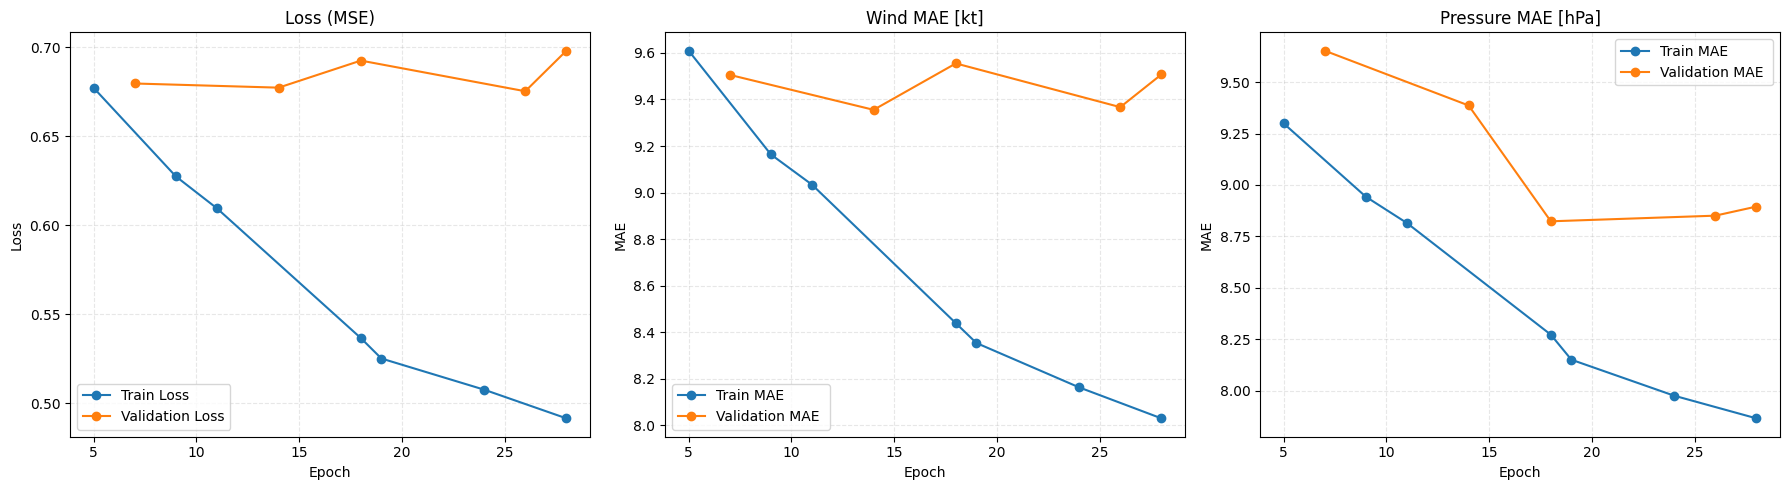

In [12]:
# Load W&B run
RUN_PATH = "ogalloethel-university-of-south-brittany/DigitalTyphoon_Regression/runs/w6tgm4rs"
api = wandb.Api()
run = api.run(RUN_PATH)
df = run.history(pandas=True)

# Extract training metrics (per epoch)
train_epoch_df = df[df["train_loss_epoch"].notna()]
epoch_train = train_epoch_df["epoch"].values
train_loss = train_epoch_df["train_loss_epoch"].values
train_mae_wind = train_epoch_df["train_mae_wind_kt_epoch"].values
train_mae_pressure = train_epoch_df["train_mae_pressure_hPa_epoch"].values

# Extract validation metrics (per epoch)
val_epoch_df = df[df["val_loss"].notna()]
epoch_val = val_epoch_df["epoch"].values
val_loss = val_epoch_df["val_loss"].values
val_mae_wind = val_epoch_df["val_mae_wind_kt"].values
val_mae_pressure = val_epoch_df["val_mae_pressure_hPa"].values

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epoch_train, train_loss, "o-", label="Train Loss")
axes[0].plot(epoch_val, val_loss, "o-", label="Validation Loss")
axes[0].set_title("Loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.3, linestyle="--")

axes[1].plot(epoch_train, train_mae_wind, "o-", label="Train MAE ")
axes[1].plot(epoch_val, val_mae_wind, "o-", label="Validation MAE ")
axes[1].set_title("Wind MAE [kt]")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].legend()
axes[1].grid(alpha=0.3, linestyle="--")

axes[2].plot(epoch_train, train_mae_pressure, "o-", label="Train MAE ")
axes[2].plot(epoch_val, val_mae_pressure, "o-", label="Validation MAE ")
axes[2].set_title("Pressure MAE [hPa]")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("MAE")
axes[2].legend()
axes[2].grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


In [ ]:
# PREDICTION
model = model           
dm    = datamodule
device = next(model.parameters()).device

dataloader = dm.test_dataloader()

# prediction loop
model.eval()

wind_true_kt_list   = []
wind_pred_kt_list   = []
press_true_hpa_list = []
press_pred_hpa_list = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Predicting"):
        images = batch["image"].to(device)
        
        preds_raw = model(images).cpu()  
                
        wind_pred_raw  = preds_raw[:, 0]
        press_pred_raw = preds_raw[:, 1]
        
        wind_true_norm  = batch["wind"].squeeze(-1)
        press_true_norm = batch["pressure"].squeeze(-1)
        
        wind_pred_kt   = wind_pred_raw.numpy()
        press_pred_hpa = -press_pred_raw.numpy()
        wind_true_kt   = wind_true_norm  * model.wind_std + model.wind_mean
        press_true_hpa = press_true_norm * model.press_std + model.press_mean
        
        wind_true_kt_list.append(wind_true_kt)
        wind_pred_kt_list.append(wind_pred_kt)
        press_true_hpa_list.append(press_true_hpa)
        press_pred_hpa_list.append(press_pred_hpa)

# Concatenate
wind_true_kt   = np.concatenate(wind_true_kt_list)
wind_pred_kt   = np.concatenate(wind_pred_kt_list)
press_true_hpa = np.concatenate(press_true_hpa_list)
press_pred_hpa = np.concatenate(press_pred_hpa_list)


print(f"Collected {len(wind_true_kt)} samples")
print(f"Wind   true: {wind_true_kt.min():.1f} – {wind_true_kt.max():.1f} kt")
print(f"Wind   pred: {wind_pred_kt.min():.1f} – {wind_pred_kt.max():.1f} kt")
print(f"Pressure true: {press_true_hpa.min():.1f} – {press_true_hpa.max():.1f} hPa")
print(f"Pressure pred: {press_pred_hpa.min():.1f} – {press_pred_hpa.max():.1f} hPa")

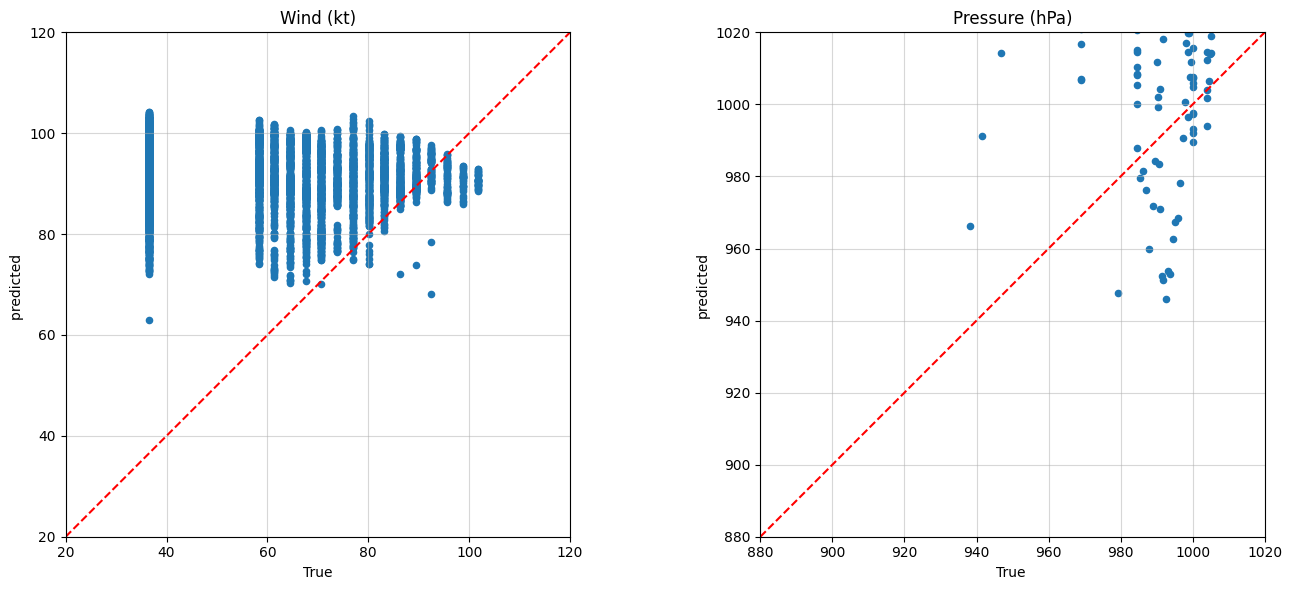

In [60]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Wind
ax1.scatter(wind_true_kt, wind_pred_kt,  s=20)
ax1.plot([20, 120], [20, 120], 'r--', lw=1.5)
ax1.set_xlim(20, 120)
ax1.set_ylim(20, 120)
ax1.set_xlabel("True")
ax1.set_ylabel("predicted ")
ax1.set_title("Wind (kt)")
ax1.grid(True, alpha=0.5)
ax1.set_aspect('equal')

# Pressure
ax2.scatter(press_true_hpa, press_pred_hpa, s=20)
ax2.plot([880, 1020], [880, 1020], 'r--', lw=1.5)
ax2.set_xlim(880, 1020)
ax2.set_ylim(880, 1020)
ax2.set_xlabel("True ")
ax2.set_ylabel("predicted")
ax2.set_title("Pressure (hPa)")
ax2.grid(True, alpha=0.5)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

**Experiment 2**

In [9]:
# Frozen backbone 
model2 = ResNet50TwoHead(
    learning_rate = 1e-4,
    dropout_rate = 0.35,
    loss_weight_wind = 1.0,
    loss_weight_pressure = 1.0,
    freeze_backbone = False
)

# RUN TRAINING
trainer2 = train_model(
    model=model2,
    datamodule=datamodule,
    max_epochs=20,
    patience=10,
    model_name="resnet50_typhoon_v1.1"
)

Downloading: "https://huggingface.co/wangyi111/softcon/resolve/62ff465b2e7467dbfc70758ec1e9d08ab87fc46b/B2_rn50_softcon.pth" to /root/.cache/torch/hub/checkpoints/B2_rn50_softcon.pth


100%|██████████| 90.0M/90.0M [00:03<00:00, 27.7MB/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Starting run: resnet50_typhoon_v1.1_lr1e-04_drop0.35_bs16


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: ogalloethel (ogalloethel-university-of-south-brittany) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone           │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ head_wind          │ Sequential        │  1.1 M │ train │     0 │
│ 2 │ head_pressure      │ Sequential        │  1.1 M │ train │     0 │
│ 3 │ criterion          │ MSELoss           │      0 │ train │     0 │
│ 4 │ train_mae_wind     │ MeanAbsoluteError │      0 │ train │     0 │
│ 5 │ train_mae_pressure │ MeanAbsoluteError │      0 │ train │     0 │
│ 6 │ val_mae_wind       │ MeanAbsoluteError │      0 │ train │     0 │
│ 7 │ val_mae_pressure   │ MeanAbsoluteError │      0 │ train │     0 │
│ 8 │ test_mae_wind      │ MeanAbsoluteError │      0 │ train │     0 │
│ 9 │ test_mae_pressure  │ MeanAbsoluteError │      0 │ train │     0 │
└───┴────────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 25.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 25.7 M                                                                                               
Total estimated model params size (MB): 102                                                                        
Modules in train mode: 240                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_mae_wind_kt improved. New best score: 8.530
Metric val_mae_wind_kt improved by 0.760 >= min_delta = 0.1. New best score: 7.770
Metric val_mae_wind_kt improved by 0.107 >= min_delta = 0.1. New best score: 7.663
Metric val_mae_wind_kt improved by 0.175 >= min_delta = 0.1. New best score: 7.488
`Trainer.fit` stopped: `max_epochs=20` reached.


Training finished in 87.8 minutes


In [ ]:
# EVALUATE ON TEST
trainer2.test(model=model2, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5967332720756531     │
│    test_loss_pressure     │    0.2609495520591736     │
│      test_loss_wind       │    0.33578357100486755    │
│   test_mae_pressure_hPa   │     8.025514602661133     │
│  test_mae_pressure_sigma  │    0.3567148745059967     │
│     test_mae_wind_kt      │     7.857549667358398     │
│    test_mae_wind_sigma    │    0.3968665599822998     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5967332720756531,
  'test_loss_wind': 0.33578357100486755,
  'test_loss_pressure': 0.2609495520591736,
  'test_mae_wind_sigma': 0.3968665599822998,
  'test_mae_pressure_sigma': 0.3567148745059967,
  'test_mae_wind_kt': 7.857549667358398,
  'test_mae_pressure_hPa': 8.025514602661133}]

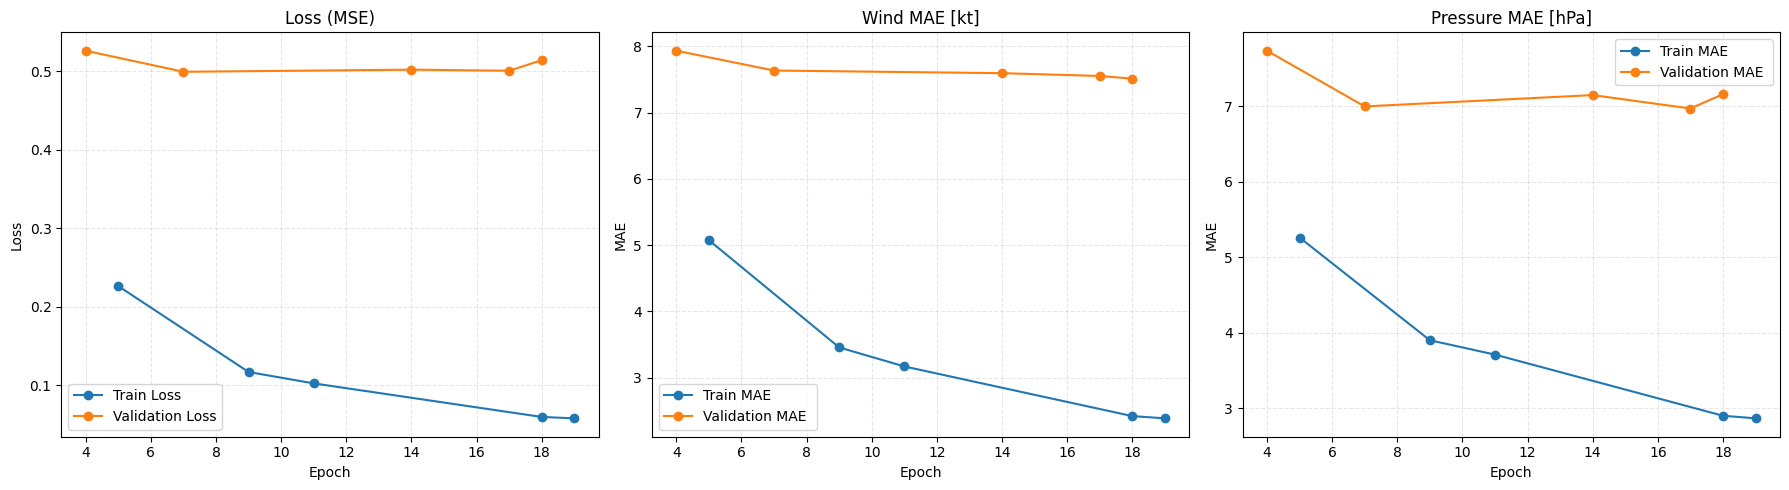

In [13]:
# Load W&B run
RUN_PATH = "ogalloethel-university-of-south-brittany/DigitalTyphoon_Regression/runs/wrcv4866"
api = wandb.Api()
run = api.run(RUN_PATH)
df = run.history(pandas=True)

# Extract training metrics (per epoch)
train_epoch_df = df[df["train_loss_epoch"].notna()]
epoch_train = train_epoch_df["epoch"].values
train_loss = train_epoch_df["train_loss_epoch"].values
train_mae_wind = train_epoch_df["train_mae_wind_kt_epoch"].values
train_mae_pressure = train_epoch_df["train_mae_pressure_hPa_epoch"].values

# Extract validation metrics (per epoch)
val_epoch_df = df[df["val_loss"].notna()]
epoch_val = val_epoch_df["epoch"].values
val_loss = val_epoch_df["val_loss"].values
val_mae_wind = val_epoch_df["val_mae_wind_kt"].values
val_mae_pressure = val_epoch_df["val_mae_pressure_hPa"].values

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epoch_train, train_loss, "o-", label="Train Loss")
axes[0].plot(epoch_val, val_loss, "o-", label="Validation Loss")
axes[0].set_title("Loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.3, linestyle="--")

axes[1].plot(epoch_train, train_mae_wind, "o-", label="Train MAE ")
axes[1].plot(epoch_val, val_mae_wind, "o-", label="Validation MAE ")
axes[1].set_title("Wind MAE [kt]")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].legend()
axes[1].grid(alpha=0.3, linestyle="--")

axes[2].plot(epoch_train, train_mae_pressure, "o-", label="Train MAE ")
axes[2].plot(epoch_val, val_mae_pressure, "o-", label="Validation MAE ")
axes[2].set_title("Pressure MAE [hPa]")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("MAE")
axes[2].legend()
axes[2].grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


#### Comparison

| Backbone |  backbone lr |head lr |Train loss | Val loss  | Wind MAE(kt) | Pressure MAE(hPa)  |  
-----------|-------------|-----------|-----------|-----------|--------------|---------------|
| True | -     |   1e-3    | 0.68      | 0.75    |  10.01    | 9.11    |
| False  | 5e-5    |    1e-4  | 0.29   |  0.54  |  8.06    |7.82    |


#### ViT

In [53]:
# MODEL
class ViTSmallTwoHead(pl.LightningModule):
    def __init__(self,
             learning_rate: float = 1e-4,
             dropout_rate: float = 0.35,
             loss_weight_wind: float = 1.2,
             loss_weight_pressure: float = 1.0,
             freeze_backbone: bool = False,
             pretrained: bool = True):
        super().__init__()
        self.save_hyperparameters()
    
        # Backbone: ViT-Small pretrained on Sentinel-1 MAE
        weights = ViTSmall16_Weights.SENTINEL1_GRD_FGMAE if pretrained else None
        self.backbone = vit_small_patch16_224(weights=weights, in_chans=2, num_classes=0)
    
        # Freeze backbone logic
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
    
        feature_size = self.backbone.embed_dim  # 384

        # Regression heads (MLP)
        def make_head():
            return nn.Sequential(
                nn.Linear(feature_size, 256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(dropout_rate * 0.6),
                nn.Linear(128, 1)
            )

        self.head_wind = make_head()
        self.head_pressure = make_head()

        # Loss and metrics
        self.criterion = nn.MSELoss()
        self.train_mae_wind = MeanAbsoluteError()
        self.train_mae_pressure = MeanAbsoluteError()
        self.val_mae_wind = MeanAbsoluteError()
        self.val_mae_pressure = MeanAbsoluteError()
        self.test_mae_wind = MeanAbsoluteError()
        self.test_mae_pressure = MeanAbsoluteError()

        # Physical units for denormalized logging
        self.wind_mean = 59.2    # knots
        self.wind_std = 19.8
        self.press_mean = 983.8  # hPa
        self.press_std = 22.5

    def forward(self, x):
        features = self.backbone(x).flatten(1)
        wind = self.head_wind(features)
        pressure = self.head_pressure(features)
        return torch.cat([wind, pressure], dim=1)

    def _shared_step(self, batch, stage="train"):
        imgs = batch["image"]
        wind_true = batch["wind"].squeeze(-1)
        press_true = batch["pressure"].squeeze(-1)

        preds = self(imgs)

        loss_wind = self.criterion(preds[:, 0], wind_true)
        loss_pressure = self.criterion(preds[:, 1], press_true)
        total_loss = self.hparams.loss_weight_wind * loss_wind + \
                     self.hparams.loss_weight_pressure * loss_pressure

        # Raw MAE
        getattr(self, f"{stage}_mae_wind")(preds[:, 0], wind_true)
        getattr(self, f"{stage}_mae_pressure")(preds[:, 1], press_true)

        # Denormalized MAE (physical units)
        with torch.no_grad():
            wind_pred_den = preds[:, 0] * self.wind_std + self.wind_mean
            wind_true_den = wind_true * self.wind_std + self.wind_mean
            press_pred_den = preds[:, 1] * self.press_std + self.press_mean
            press_true_den = press_true * self.press_std + self.press_mean

            mae_wind_den = torch.mean(torch.abs(wind_pred_den - wind_true_den))
            mae_press_den = torch.mean(torch.abs(press_pred_den - press_true_den))

        # Logging
        prefix = stage
        self.log(f"{prefix}_loss", total_loss, on_epoch=True)
        self.log(f"{prefix}_loss_wind", loss_wind, on_epoch=True)
        self.log(f"{prefix}_loss_pressure", loss_pressure, on_epoch=True)
        self.log(f"{prefix}_mae_wind_sigma", getattr(self, f"{stage}_mae_wind"), on_epoch=True)
        self.log(f"{prefix}_mae_pressure_sigma", getattr(self, f"{stage}_mae_pressure"), on_epoch=True)
        self.log(f"{prefix}_mae_wind_kt", mae_wind_den, on_epoch=True)
        self.log(f"{prefix}_mae_pressure_hPa", mae_press_den, on_epoch=True)

        return total_loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")

    def configure_optimizers(self):
    # Split parameters into backbone and heads
        backbone_params = [p for p in self.backbone.parameters() if p.requires_grad]
        head_params = list(self.head_wind.parameters()) + list(self.head_pressure.parameters())

        if len(backbone_params) == 0:
            optimizer = optim.AdamW(head_params, lr=1e-4, weight_decay=5e-5)
        else:
            optimizer = optim.AdamW([
                {"params": backbone_params, "lr": 5e-5}, 
                {"params": head_params, "lr": 1e-4}
            ], weight_decay=5e-5)
    
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=4
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }


In [55]:
# Frozen backbone 
model = ViTSmallTwoHead(
    learning_rate = 1e-3,
    dropout_rate = 0.35,
    loss_weight_wind = 1.0,
    loss_weight_pressure = 1.0,
    freeze_backbone = True
)

# RUN TRAINING
trainer = train_model(
    model=model,
    datamodule=datamodule,
    max_epochs=50,
    patience=20,
    model_name="ViTsmall_typhoon_v1.2"
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Starting run: ViTsmall_typhoon_v1.2_lr1e-03_drop0.35_bs16


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name               ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone           │ VisionTransformer │ 21.6 M │ train │     0 │
│ 1 │ head_wind          │ Sequential        │  131 K │ train │     0 │
│ 2 │ head_pressure      │ Sequential        │  131 K │ train │     0 │
│ 3 │ criterion          │ MSELoss           │      0 │ train │     0 │
│ 4 │ train_mae_wind     │ MeanAbsoluteError │      0 │ train │     0 │
│ 5 │ train_mae_pressure │ MeanAbsoluteError │      0 │ train │     0 │
│ 6 │ val_mae_wind       │ MeanAbsoluteError │      0 │ train │     0 │
│ 7 │ val_mae_pressure   │ MeanAbsoluteError │      0 │ train │     0 │
│ 8 │ test_mae_wind      │ MeanAbsoluteError │      0 │ train │     0 │
│ 9 │ test_mae_pressure  │ MeanAbsoluteError │      0 │ train │     0 │
└───┴────────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 263 K                                                                                            
Non-trainable params: 21.6 M                                                                                       
Total params: 21.8 M                                                                                               
Total estimated model params size (MB): 87                                                                         
Modules in train mode: 299                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_mae_wind_kt improved. New best score: 16.102
Metric val_mae_wind_kt improved by 0.148 >= min_delta = 0.1. New best score: 15.954
Metric val_mae_wind_kt improved by 0.140 >= min_delta = 0.1. New best score: 15.815
Metric val_mae_wind_kt improved by 0.177 >= min_delta = 0.1. New best score: 15.638
Metric val_mae_wind_kt improved by 0.130 >= min_delta = 0.1. New best score: 15.508
Metric val_mae_wind_kt improved by 0.190 >= min_delta = 0.1. New best score: 15.317
Metric val_mae_wind_kt improved by 0.132 >= min_delta = 0.1. New best score: 15.186
`Trainer.fit` stopped: `max_epochs=50` reached.


Training finished in 215.4 minutes


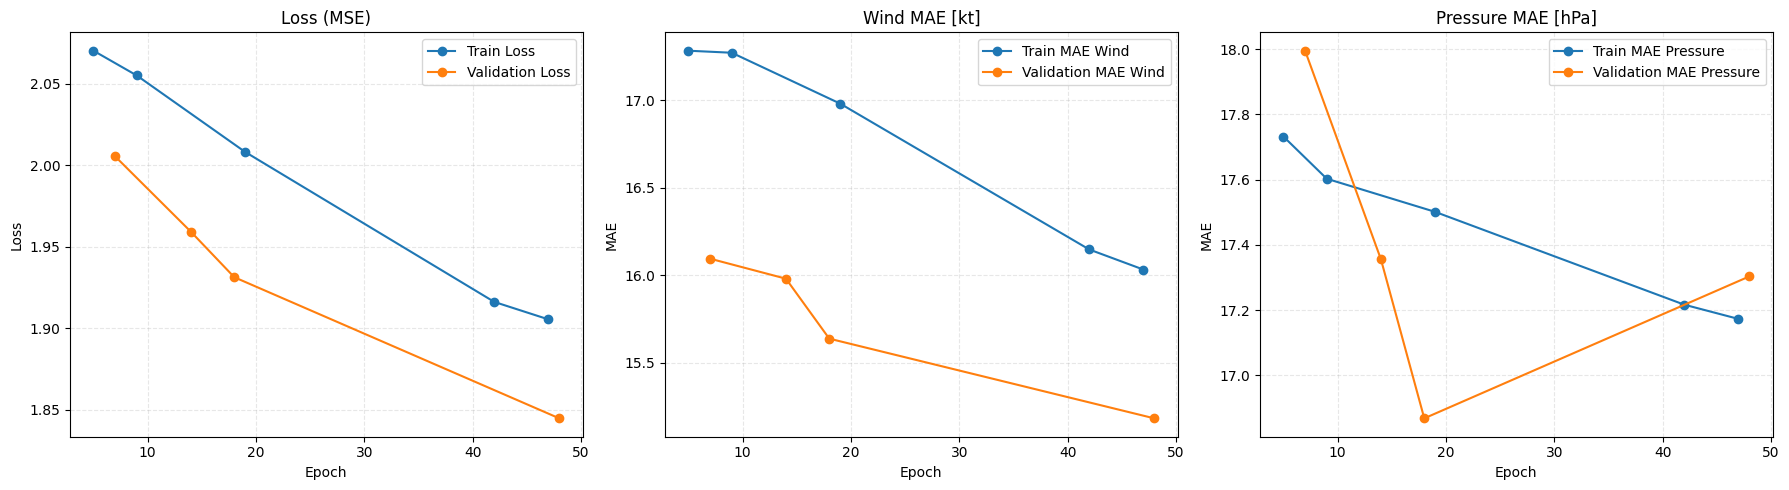

In [73]:
# Load W&B run
RUN_PATH = "ogalloethel-university-of-south-brittany/DigitalTyphoon_final/runs/chr9kutz"
api = wandb.Api()
run = api.run(RUN_PATH)
df = run.history(pandas=True)

# Extract training metrics (per epoch)
train_epoch_df = df[df["train_loss_epoch"].notna()]
epoch_train = train_epoch_df["epoch"].values
train_loss = train_epoch_df["train_loss_epoch"].values
train_mae_wind = train_epoch_df["train_mae_wind_kt_epoch"].values
train_mae_pressure = train_epoch_df["train_mae_pressure_hPa_epoch"].values

# Extract validation metrics (per epoch)
val_epoch_df = df[df["val_loss"].notna()]
epoch_val = val_epoch_df["epoch"].values
val_loss = val_epoch_df["val_loss"].values
val_mae_wind = val_epoch_df["val_mae_wind_kt"].values
val_mae_pressure = val_epoch_df["val_mae_pressure_hPa"].values

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(epoch_train, train_loss, "o-", label="Train Loss")
axes[0].plot(epoch_val, val_loss, "o-", label="Validation Loss")
axes[0].set_title("Loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.3, linestyle="--")

axes[1].plot(epoch_train, train_mae_wind, "o-", label="Train MAE Wind")
axes[1].plot(epoch_val, val_mae_wind, "o-", label="Validation MAE Wind")
axes[1].set_title("Wind MAE [kt]")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].legend()
axes[1].grid(alpha=0.3, linestyle="--")

axes[2].plot(epoch_train, train_mae_pressure, "o-", label="Train MAE Pressure")
axes[2].plot(epoch_val, val_mae_pressure, "o-", label="Validation MAE Pressure")
axes[2].set_title("Pressure MAE [hPa]")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("MAE")
axes[2].legend()
axes[2].grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


In [87]:
ckpt_path = "/kaggle/working/ViTsmall_typhoon_v1.2.ckpt"  # or wherever your checkpoint is
model = ViTSmallTwoHead.load_from_checkpoint(ckpt_path, map_location="cuda")
model.eval()
model.freeze()  # disable gradients


trainer = pl.Trainer(
    accelerator="gpu",  # or "cpu" if no GPU
    devices=1,
    logger=False,       # <- important: disables W&B logging
    enable_checkpointing=False
)
# run test
test_results = trainer.test(model=model, datamodule=datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.6144944429397583     │
│    test_loss_pressure     │    0.7842378616333008     │
│      test_loss_wind       │    0.8302567601203918     │
│   test_mae_pressure_hPa   │    16.322349548339844     │
│  test_mae_pressure_sigma  │    0.7254379987716675     │
│     test_mae_wind_kt      │    15.447393417358398     │
│    test_mae_wind_sigma    │    0.7801717519760132     │
└───────────────────────────┴───────────────────────────┘

### References:
1. Kitamoto, A., Dzik, E., & Faure, G. (2024). Machine Learning for the Digital Typhoon Dataset: Extensions to Multiple Basins and New Developments in Representations and Tasks (No. arXiv:2411.16421). arXiv. https://doi.org/10.48550/arXiv.2411.16421
2. Kitamoto, A., Hwang, J., Vuillod, B., Gautier, L., Tian, Y., & Clanuwat, T. (2023). Digital Typhoon: Long-term Satellite Image Dataset for the Spatio-Temporal Modeling of Tropical Cyclones (No. arXiv:2311.02665). arXiv. https://doi.org/10.48550/arXiv.2311.02665

